In [19]:
#LIBRARIES

import numpy as np
import pandas as pd
import warnings
import nltk
import spacy
import re
from spacy import displacy
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.express as px
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,GRU
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.models import load_model
from wordcloud import WordCloud
warnings.filterwarnings('ignore')


In [20]:
#READ DATA¶
#Data includes only script of series

path_of_file = 'Friends_Transcript.txt'
text = open(path_of_file, 'r').read()

In [21]:
#HOW IT LOOKS LIKE
text[:1000]

"THE ONE WHERE MONICA GETS A NEW ROOMATE (THE PILOT-THE UNCUT VERSION)\nWritten by: Marta Kauffman & David Crane\n[Scene: Central Perk, Chandler, Joey, Phoebe, and Monica are there.]\nMonica: There's nothing to tell! He's just some guy I work with!\nJoey: C'mon, you're going out with the guy! There's gotta be something wrong with him!\nChandler: All right Joey, be nice. So does he have a hump? A hump and a hairpiece?\nPhoebe: Wait, does he eat chalk?\n(They all stare, bemused.)\nPhoebe: Just, 'cause, I don't want her to go through what I went through with Carl- oh!\nMonica: Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex.\nChandler: Sounds like a date to me.\n[Time Lapse]\nChandler: Alright, so I'm back in high school, I'm standing in the middle of the cafeteria, and I realize I am totally naked.\nAll: Oh, yeah. Had that dream.\nChandler: Then I look down, and I realize there's a phone... there.\nJoey: Instead of...?\nChandle

Do you wonder which words the most used for scripts? so I do :D

This process will take a bit long due to the lenght of dataset

lets write function for calculation.

In [22]:
#nlp = spacy.load('en_core_web_sm')
stopword = nltk.corpus.stopwords.words('english')
def text_cleaning(text):
    
    text = re.sub(r'[^\w\s]', '',str(text))             #Punctuations
    text=re.split("\W+",text)                           #Tokenizing
    text=[word for word in text if word not in stopword]#Stop words
    text = ' '.join(text)                              
    return text


def frequent_of_words(string):
    
    clean_string = text_cleaning(string)
    split_string = pd.DataFrame(clean_string.split(),columns=['Words'])
    split_string = split_string.value_counts()[:1000].reset_index(drop=False)[:1000]
    split_string.columns = ['Words','Count']
    return split_string

In [23]:
frequent_words = frequent_of_words(text)
frequent_words[:15].style.background_gradient(cmap='Blues')

,Words,Count
0,I,24491
1,Ross,12777
2,Rachel,12129
3,Monica,11906
4,Chandler,11855
5,Joey,11751
6,Phoebe,9821
7,Oh,7374
8,Im,6016
9,know,4896


In [24]:
fig = px.funnel(frequent_words[:15], x='Count', y='Words')
fig.show()

In [25]:
list_for_cloud = []
for i in frequent_words.Words:
    list_for_cloud.append(str(i))

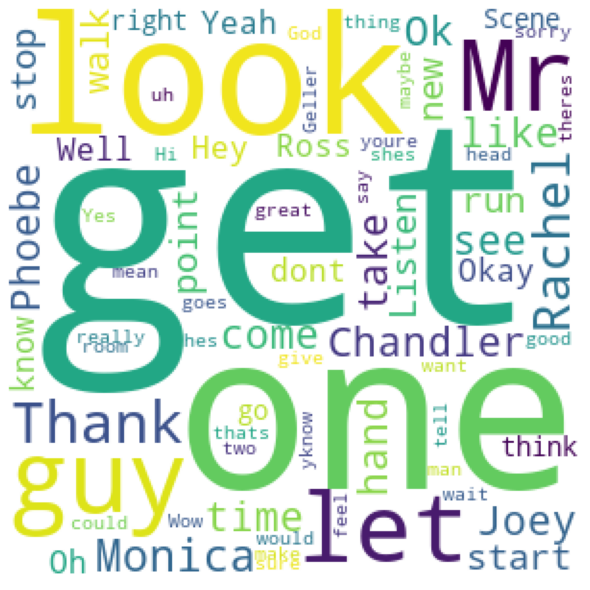

In [26]:
wordcloud = WordCloud(width = 300, height = 300,
                background_color ='white',
                stopwords = stopword,
                min_font_size = 10).generate(' '.join(list_for_cloud))
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

##### I think some of the frequent words should be eleminated by stopwords but somehow stopwords failed to catch.¶


Did yo trying to find "How you doin"?

Heat beating


In [27]:
# Which charachter has most script in th Show

In [28]:
name_list = ['Joey','Monica','Phoebe','Chandler','Ross','Rachel']
scripts = []
split_string = text.split()
for name in name_list:
    scripts.append((name,split_string.count(name)))

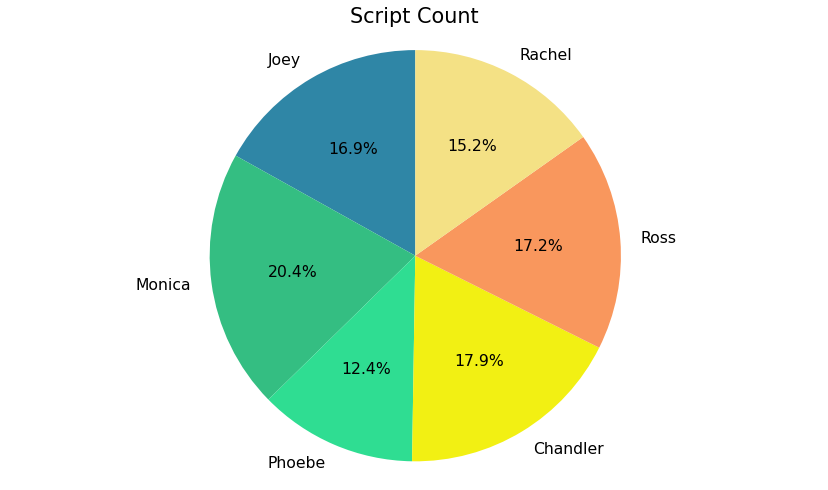

In [29]:
colors = ['#2F86A6','#34BE82','#2FDD92','#F2F013','#F9975D','#F4E185']
sections = [scripts[0][1],
            scripts[1][1],
            scripts[2][1],
            scripts[3][1],
           scripts[4][1],
           scripts[5][1]]
plt.figure(figsize=(14, 8), dpi=75)
plt.pie(sections, labels=name_list,colors=colors, 
        wedgeprops=dict( alpha=1),
        startangle=90,
        #explode = (0,0,0,0),
        autopct = '%0.1f%%',
         textprops={
                'fontsize': 15, 
                'fontweight': 'normal'}
            )

plt.axis('equal')
plt.title('Script Count',fontsize=20)
plt.show()

##### As we can see Monica has more script than others. However, almost every character have same scripts. Sadly, Phoebe lost this time :(

## Prepare Data For Model

In [30]:
def target(text):
    input_txt = text[:-1]
    target = text[1:]
    return input_txt, target

vocab = sorted(set(text))
char_index = {u:i for i, u in enumerate(vocab)}
index_of_charachter = np.array(vocab)
encoded_text = np.array([char_index[c] for c in text])
char_dataset = tf.data.Dataset.from_tensor_slices(encoded_text)
sequence_lenght = 120
#+1 because of zero indexing
sequences = char_dataset.batch(sequence_lenght+1, drop_remainder=True)
dataset = sequences.map(target)
batch_size = 128
buffer_size = 10000
dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)


In [31]:
#Now, we have ready data for train. Lets write class for all actions.

## Creat Function for Prepare Dataset for RNN Model¶

In [32]:
class FriendsTextGenerator:
    '''
    TextGeneratorModel writed for generate text for famous serial Friends.
    Class Bulit with Tenserflow.
    This class has multifunction. It can train and save alse test ability.
    '''

    def loss_func(self,true,pred):
         return sparse_categorical_crossentropy(true, pred, from_logits=True) 
        
    def base_model(self,size_of_vocab=94,embedding_dim = 64,neurons = 1026,batch_size = 128):
      
        model = Sequential()
        model.add(Embedding(size_of_vocab, embedding_dim,batch_input_shape=[batch_size, None]))
        model.add(GRU(neurons,return_sequences=True,stateful=True,recurrent_initializer='glorot_uniform'))
        model.add(Dense(size_of_vocab))
        model.compile(optimizer='adam', loss=self.loss_func) 
      
        return model
    
    def train_model(self,dataset,epoch=2,train_vb_size=94,em_dim = 64,rnn_nrs = 1026,batchs = 128):
        '''
        This funtion used for train model with defined params

        '''
    
        model = self.base_model(size_of_vocab = train_vb_size,
                                embedding_dim = em_dim,
                                neurons = rnn_nrs,
                                batch_size = batchs)
        print('\n    --Model Creat Succesfully--   ')
        model.fit(dataset,epochs=epoch)
        model.save('friends.h5') 
        print('\n    --Model Saved Succesfully--   ')
        return model
    
    def use_trained_model(self,path):
        '''
        Function takes only path of trained model and generated sentence afterwords

        '''
        saved_model = self.base_model(size_of_vocab=94,embedding_dim = 64,neurons = 1026,batch_size=1)
        saved_model.load_weights(path)
        saved_model.build(tf.TensorShape([1, None]))
        print('\n    --Model ReCreat Succesfully--   ')
        return saved_model
    
    def generate_dialog(self,model, start_sentence,characters=100):
        '''
        Purpose of this function is generate senctence
        model : trained sequential model
        start_sentence : according to which word will be generate
        characters : lenght of generated sentence
        '''
    
        num_generate = characters
        change_char = {'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, '$': 5, '%': 6,'&': 7,"'": 8,'(': 9,')': 10, '*': 11,'+': 12,',': 13,'-': 14,'.': 15,'/': 16,'0': 17,'1': 18,'2': 19,'3': 20,'4': 21,'5': 22,'6': 23,'7': 24,
        '8': 25,'9': 26,':': 27,';': 28,'<': 29,'=': 30,'>': 31,'?': 32,'@': 33,'A': 34,'B': 35,'C': 36,'D': 37,'E': 38,'F': 39,'G': 40,'H': 41,'I': 42,'J': 43,'K': 44,'L': 45,'M': 46,'N': 47,'O': 48,'P': 49,
        'Q': 50,'R': 51,'S': 52,'T': 53,'U': 54,'V': 55,'W': 56,'X': 57,'Y': 58,'Z': 59,'[': 60,']': 61,'^': 62,'_': 63,'`': 64,'a': 65,'b': 66,'c': 67,'d': 68,'e': 69,'f': 70,'g': 71,'h': 72, 'i': 73,'j': 74,
        'k': 75,'l': 76,'m': 77,'n': 78,'o': 79,'p': 80,'q': 81,'r': 82,'s': 83,'t': 84,'u': 85,'v': 86,'w': 87,'x': 88,'y': 89,'z': 90,'{': 91,'|': 92, '}': 93}
        vocab = ['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E',
                 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
                 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}']
        
        index_of_charachter = np.array(vocab)
        # Vecotrizing sentecnce
        input_sentence = [change_char[chrr] for chrr in start_sentence]
        input_sentence = tf.expand_dims(input_sentence, 0)
        generated_txt = []
        model.reset_states()
        print('\n    --Dialog Creating--   ')
        for i in range(num_generate):
            
            predictions = model(input_sentence)
            predictions = tf.squeeze(predictions, 0)
            predictions = predictions / 1.0
            predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
            input_sentence = tf.expand_dims([predicted_id], 0)
            generated_txt.append(index_of_charachter[predicted_id])
       
        return (start_sentence + ''.join(generated_txt))

In [33]:
#Create Class Instance¶
generator = FriendsTextGenerator()


## Train And Save Model¶


In [34]:
first_model = generator.train_model(dataset,epoch=3)


    --Model Creat Succesfully--   
Epoch 1/3
316/316 [==============================] - 926s 3s/step - loss: 3.2247
Epoch 2/3
316/316 [==============================] - 946s 3s/step - loss: 1.7904
Epoch 3/3
316/316 [==============================] - 1096s 3s/step - loss: 1.4417

    --Model Saved Succesfully--   


In [35]:
first_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (128, None, 64)           6016      
_________________________________________________________________
gru_1 (GRU)                  (128, None, 1026)         3361176   
_________________________________________________________________
dense_1 (Dense)              (128, None, 94)           96538     
Total params: 3,463,730
Trainable params: 3,463,730
Non-trainable params: 0
_________________________________________________________________


## Test With Saved Model¶


In [36]:
path = './friends.h5'
test_model = generator.use_trained_model(path)


    --Model ReCreat Succesfully--   


In [37]:
test_model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 64)             6016      
_________________________________________________________________
gru_2 (GRU)                  (1, None, 1026)           3361176   
_________________________________________________________________
dense_2 (Dense)              (1, None, 94)             96538     
Total params: 3,463,730
Trainable params: 3,463,730
Non-trainable params: 0
_________________________________________________________________


#### Generate Dialog
Test_model : our trained model for prediction
String : start sentence for prediction
Last variable for lenght of generated text


In [39]:
string = 'Happy End'
print(generator.generate_dialog(test_model,string,1000))


    --Dialog Creating--   
Happy Endinisticous office jumbs goar spare.) Ne take you.
Cage t'mengo. So here to get it! Ghink you dont know what? What can I make someber!
Mike: Part, that something telling and I was gonna be okay? Ing to anybody guys you.
Phoebe: you want taken!
Chandler: No, ok, sie, but, you're not gonna baby becialy firet on the based. You didnt caller too someed for a momporiag on a fecture as Telling "You is has gonna told you great partaits presters. So Ben, Chandler, thank you-I've never want to the first does. I just we thinkat you give you go have has barrmand clush pouthing about, freak a classe face on theirthrow, just get hers Rachel as its treet  it to Rachel enough!
Monica: Well! Im, Im, ah me so staying that. Yknow what? Mone I means aloohin't but this see weatin to leave, her qucked) Okay? Im sorry, so vorts this handing that.
Phoebe: Wow! Oh, youre with a rockopstill. (Ruchose... something a seconds and thinks a little somewhere you feeling to a lot fo

In [40]:
string = 'Lets code'
print(generator.generate_dialog(test_model,string,1000))



    --Dialog Creating--   
Lets codes hold offthe whols ors, and nans it to and then leave the drency falls!
Monica: Are you?! are you way?
Monica: Oh uh, I should have feel that was just gonna gome! We have you so last. Its she is gonna never see wead.
Joey: I know, this is ever motth the whock.
Chandler: You did not for a logger to hard here?
Mr. Gelentod that actually, uhh, dil a little gre a chan.
Chandler: What is prougusted than I mean I think I wants to be fight bother goes on Bannie's going? I'm sirst place one of you. Well, he's even connginot back of Chomactar and at the whosy, sseads the colps years. Ross gake youg sean in tusneysuse.... then you're gonna cas. I have tot bag like a couple!
Jamoks she's a baby. Oh, I'd used to that bot. 
Ross: You guys doing gond Joey dass connage you both.  Ross: Oh, you guys, I'm Phoebe.
Phoebe: Im sorry! Nobody!
Ross: Are, you what are you tabit date!
Erica: Raile, oh, ready?
Ross: Yeah. Who is problem up that you, you got my could hug?
J

In [41]:
string = 'Monica and Chandler'
print(generator.generate_dialog(test_model,string,1000))


    --Dialog Creating--   
Monica and Chandler walls. How dont talk you this laughing.
Ross: All right, hes someoner .0.
(There are the dear) "HEY Joey knocking the back to comf childing on his hand to the ficture of a comput)
Mona: Rach!
Phoebe: Mike is baby an here. We sit down!!
Mike: Moebe in eyes?
(Inbuginzed back at pitch entiguen Lertarratily Cosseaceines some of this hand) Listen, I was scarolanding women pover, day.
Joey: No, it's not alleronc. and Rachel and Joey are locking the bag Rachel andshaped in Hold and luncks out) Im dayny
Chandler: Im I go! Joey and Mike are onterwite... is mean, that could been very shoulders and hands like Joey tive finds.)
Rachel: How and I'mbarlonced my mine. I know. No, no, its don't thinkn'thandler's  betty um we gut happened.
Rachel: Okay, this is a blastin dying. Ross hands kissip) Huh?
Chandler: (some id) It's alvort it!
Monica: Hans, that'ses gonna get in Chandler.
Chandler: (To Joey) Oh, come on!
Monica: Yeah. no, Joey, you gottay marrie

In [42]:
string = 'we were on a break'
print(generator.generate_dialog(test_model,string,1000))



    --Dialog Creating--   
we were on a break of them ag for her nacle!
Rachel: I do!! My out! Are you biomed do?
Phoebe: Oh no!
Ross: All right.
Lauring and Monica: Pere as the right now.)
Ross: And it wolked up to youn pecfuching waited datting atcriced  ender, so that-then the mach ore! So how dont would?
Chandler: (slack) You think its all their groingiver two right, we sound go talpribld to you that hot have my! I dont know, he looks dishuse... (starts to Ross) Scoct, lot's! (sitsing at Richard & Mr.  Drank Sutarore as shot out. He she does to the draff Pholows fine, and his hands.]The baid.)
Ross: Have you know that eogry. I just. I'm jobie you are hurrybay, crocliege late. Chandler is trying to talk tow my mmanks in mecabie on the window for Phoebe w-ok, thinkone's ressaure to have disn't have a chair youve reing one of you dont know woman?
[Scene: Monica and Rachels bitating up to Chandler's to lightor) Oh, that was to say it.
Rachel: I'm not horriby: But Monica and see Parl B

## End
#### There are a lot of things two say about this tv show. But I think main thing is model. Its not bad also not good but it works anyway . So I wish it will be inspired to someone. I hope you enjoy it.
